# IMBD Review challenge. 

### Prerequisites:
 - Numpy
 - Tensorflow
 - Keras
 - Globe embeddings (http://nlp.stanford.edu/data/glove.6B.zip)

### Logic
 1. Load data
 2. Explore data
 3. Split data into training, validation and test sets
 4. Vectorize data
 5. Try models
    - Glove
    - LSTM


**1. Load data**
***

In [1]:
import os 
import random
import numpy as np


def load_imdb_reviews(data_path, seed=4):
    """Loads the IMDB reviews text files containing positive, negative and unsupervised (not used) reviews.
       Shuffles the data

    # Arguments
        data_path: string, path to the data directory.

    # Returns
        Lists: texts and labels.
        Number of samples: 50000
        Number of categories: 2 (0 - negative, 1 - positive)

    """
    
    negative_reviews_file='negative_reviews.txt'
    positive_reviews_file='positive_reviews.txt'
    unsupervised_reviews_file='unsupervised_reviews.txt'
    labels = []
    texts = []
    
    # Load negative reviews
    with open(os.path.join(reviews_dir, negative_reviews_file)) as f:
      for line in f:
        texts.append(line)
        labels.append(0)
    # Load positive reviews
    with open(os.path.join(reviews_dir, positive_reviews_file)) as f:
      for line in f:
        texts.append(line)
        labels.append(1)

    # Shuffle the texts and labels.
    random.seed(seed)
    random.shuffle(texts)
    random.seed(seed)
    random.shuffle(labels)
    
    return texts, labels

In [2]:

reviews_dir = '~/dev/NLP/nlp-challenge'

texts, labels = load_imdb_reviews(reviews_dir)

print('Shape of texts list:', len(texts))
print('Shape of labels list:', len(labels))

Shape of texts list: 50000
Shape of labels list: 50000


**2. Explore data**
***

In [3]:

from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()
    
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
    # Returns
        int, total number of classes.
    """
    num_classes = max(labels) + 1
    return num_classes

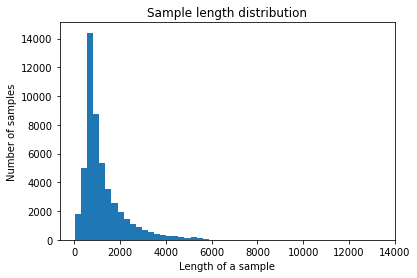

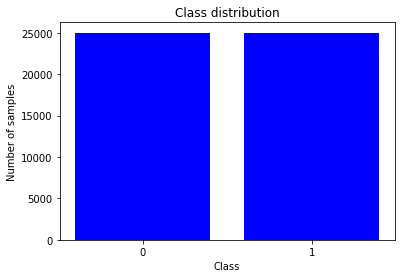

In [4]:
plot_sample_length_distribution(texts)
plot_class_distribution(labels)

**3. Split data into training, validation and test sets**
***

In [5]:

def split_sets(texts, labels, training_samples, validation_samples, test_samples):
    """Splits the texts and labels into training, validation and test sets.
    # Arguments
        texts: list, text data.
        labels: list, label data.
        traning_samples: int, number of samples to use for training.
        validation_samples: int, number of samples to use for validation.
        test_samples: int, number of samples to use for test.

    # Returns
        Training, validation and test lists.
    """
    x_train = texts[:training_samples]
    y_train = labels[:training_samples]
    x_val = texts[training_samples: training_samples + validation_samples]
    y_val = labels[training_samples: training_samples + validation_samples]
    x_test = texts[training_samples + validation_samples:training_samples + validation_samples + test_samples]
    y_test = labels[training_samples + validation_samples:training_samples + validation_samples + test_samples]
    
    return x_train, y_train, x_val, y_val, x_test, y_test


In [6]:
training_samples = 40000
validation_samples = 5000
test_samples = 5000

x_train, y_train, x_val, y_val, x_test, y_test=split_sets(texts, labels, training_samples, validation_samples, test_samples)

print('Length of training list:', len(x_train), len(y_train))
print('Length of validation list:',  len(x_val), len(y_val))
print('Length of test list:',  len(x_test), len(y_test))


Length of training list: 40000 40000
Length of validation list: 5000 5000
Length of test list: 5000 5000


**4. Vectorize data**
***

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


def sequence_vectorize(texts, labels, max_words_to_keep, max_review_length):
    """Vectorizes texts as sequence vectors. Converts labels into tensor.
    # Arguments
        texts: list, text data.
        labels: list, label data.
        max_words_to_keep: int, maximum number of words to keep in dataset.
        max_review_length: int, maximum number of words to process from the review.
    # Returns
        Vectorized texts, labels tensor and word index dictionary.
    """
    tokenizer = Tokenizer(num_words=max_words_to_keep)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=max_review_length)

    labels = np.asarray(labels)

    return data, labels, word_index

Using TensorFlow backend.


In [8]:
max_words_to_keep = 10000
max_review_length = 100

x_train, y_train, word_index =sequence_vectorize(x_train, y_train, max_words_to_keep, max_review_length)
x_val, y_val, _ =sequence_vectorize(x_val, y_val, max_words_to_keep, max_review_length)
x_test, y_test, _ =sequence_vectorize(x_test, y_test, max_words_to_keep, max_review_length)


print('Shape of test tensor:', x_train.shape, y_train.shape)
print('Shape of validation tensor:',  x_val.shape,  y_val.shape)
print('Shape of test tensor:',  x_test.shape,  y_test.shape)
print('Found %s unique tokens.' % len(word_index))

Shape of test tensor: (40000, 100) (40000,)
Shape of validation tensor: (5000, 100) (5000,)
Shape of test tensor: (5000, 100) (5000,)
Found 90965 unique tokens.


**5.1 Glove model**
***

In [9]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    """Helper function to plot training and validation accuracy and loss
    # Arguments
        Model history
    # Returns
        None. Plots 2 charts: 
        - Training and validation accuracy
        - Training and validation loss
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [10]:
def load_glove_embeddings(glove_dir, glove_embeddings):
    """
    # Arguments
        glove_dir: path to folder containing glove vectors.
        glove_embeddings: name of file with glove vectors.
    # Returns
        Embedding index.
    """
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index


In [11]:
glove_dir = '~/dev/NLP/glove.6B/'
glove_embeddings='glove.6B.100d.txt'
embeddings_index=load_glove_embeddings(glove_dir, glove_embeddings)

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
def build_embeddings_matrix(embedding_dim, max_words_to_keep):
    """
    # Arguments
        embedding_dim: int, dimension of embedding matrix.
        max_words_to_keep: int, maximum number of words to keep in dataset.
    # Returns
        Embedding index.
    """
    embedding_matrix = np.zeros((max_words_to_keep, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words_to_keep:
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


In [13]:
embedding_dim = 100
embedding_matrix=build_embeddings_matrix(embedding_dim, max_words_to_keep)


In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

def train_glove_model(x_train, y_train, x_val, y_val, max_words_to_keep, max_review_length, embedding_dim, embedding_matrix):
    """
    # Arguments
        x_train, y_train: train tensors.
        x_val, y_val: validation tensors.
        max_words_to_keep: int, maximum number of words to keep in dataset.
        max_review_length: int, maximum number of words to process from the review.
        embedding_dim: dimension of embedding matrix
        embedding_matrix:
    # Returns
        Trained model and model history.
    """
    model = Sequential()
    model.add(Embedding(max_words_to_keep, embedding_dim, input_length=max_review_length))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
    history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
    return model, history


Train on 40000 samples, validate on 5000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 154us/step - loss: 0.6005 - acc: 0.6732 - val_loss: 0.7881 - val_acc: 0.5182
Epoch 2/10
40000/40000 [==============================] - 6s 147us/step - loss: 0.5038 - acc: 0.7551 - val_loss: 0.8064 - val_acc: 0.5152
Epoch 3/10
40000/40000 [==============================] - 6s 147us/step - loss: 0.4631 - acc: 0.7784 - val_loss: 0.8512 - val_acc: 0.5112
Epoch 4/10
40000/40000 [==============================] - 6s 149us/step - loss: 0.4297 - acc: 0.8001 - val_loss: 0.9179 - val_acc: 0.5104
Epoch 5/10
40000/40000 [==============================] - 6s 154us/step - loss: 0.3985 - acc: 0.8130 - val_loss: 0.9549 - val_acc: 0.5100
Epoch 6/10
40000/40000 [==============================] - 6s 156us/step - loss: 0.3710 - acc: 0.8277 - val_loss: 1.0304 - val_acc: 0.5108
Epoch 7/10
40000/40000 [==============================] - 6s 156us/step - loss: 0.3401 - acc: 0.8429 - val_loss: 1.1593 - v

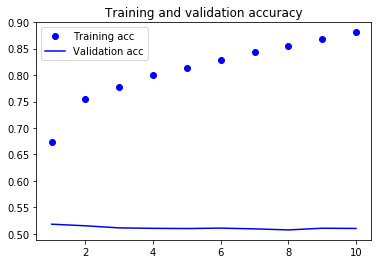

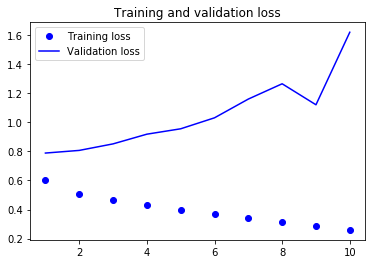

In [19]:
%matplotlib inline

model_glove, history_glove = train_glove_model(x_train, y_train, x_val, y_val, max_words_to_keep, max_review_length, embedding_dim, embedding_matrix)
model_glove.summary()
model_glove.save('model_glove.h5')
plot_loss_and_accuracy(history_glove)

In [18]:
import tensorflow as tf 
tf.logging.set_verbosity(tf.logging.ERROR)

In [20]:
scores = model_glove.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 54.22%


**5.2 LSTM model**
***

In [21]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


def train_lstm_model(x_train, y_train, x_val, y_val, max_words_to_keep):
    """
    # Arguments
        x_train, y_train: train tensors.
        x_val, y_val: validation tensors.
        max_words_to_keep: int, maximum number of words to keep in dataset.
    # Returns
        Trained model and model history.
    """
    model = Sequential()
    model.add(Embedding(max_words_to_keep, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    history = model.fit(x_train, y_train,
                        epochs=10,
                        batch_size=128,
                        validation_data=(x_val, y_val))
    return model, history


Train on 40000 samples, validate on 5000 samples
Epoch 1/10
40000/40000 [==============================] - 79s 2ms/step - loss: 0.4180 - acc: 0.8057 - val_loss: 1.1330 - val_acc: 0.5274
Epoch 2/10
40000/40000 [==============================] - 81s 2ms/step - loss: 0.2952 - acc: 0.8772 - val_loss: 1.0703 - val_acc: 0.5324
Epoch 3/10
40000/40000 [==============================] - 82s 2ms/step - loss: 0.2661 - acc: 0.8909 - val_loss: 0.9585 - val_acc: 0.5318
Epoch 4/10
40000/40000 [==============================] - 83s 2ms/step - loss: 0.2494 - acc: 0.8990 - val_loss: 1.3086 - val_acc: 0.5278
Epoch 5/10
40000/40000 [==============================] - 83s 2ms/step - loss: 0.2372 - acc: 0.9035 - val_loss: 1.0328 - val_acc: 0.5362
Epoch 6/10
40000/40000 [==============================] - 83s 2ms/step - loss: 0.2258 - acc: 0.9099 - val_loss: 1.0835 - val_acc: 0.5340
Epoch 7/10
40000/40000 [==============================] - 83s 2ms/step - loss: 0.2153 - acc: 0.9143 - val_loss: 1.2028 - val_acc:

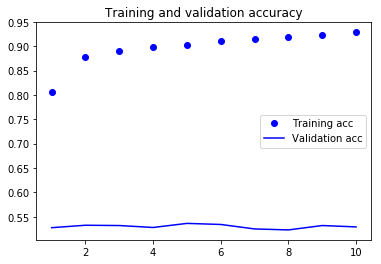

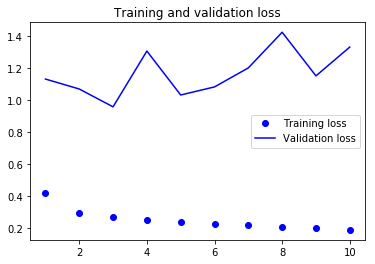

In [22]:

model_lstm, history_lstm = train_lstm_model(x_train, y_train, x_val, y_val, max_words_to_keep)
model_lstm.summary()
model_lstm.save('model_lstm.h5')
plot_loss_and_accuracy(history_lstm)

In [23]:
scores = model_lstm.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 53.34%
